# Attention Monitoring

Performed image and video classification with a Convolutional Neural Network in Python using TensorFlow Keras.

Fine-tuned the top layers of a [ResNet-152](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet152) model, pre-trained with the [ImageNet](https://image-net.org/) dataset. I then used that to classify video clips, and then to classify live video feed.

Project Structure

├── Attention Monitoring
│   ├── .git
│   ├── .gitignore
│   ├── .ipynb_checkpoints
│   ├── Attention Monitoring.ipynb
│   ├── graphs
│   ├── data
│   │   ├── test
│   │   │   ├── attentive
│   │   │   └── notattentive
│   │   ├── test_combined
│   │   ├── train
│   │   │   ├── attentive
│   │   │   └── notattentive
│   │   ├── valid
│   │   │   ├── attentive
│   │   │   └── notattentive
│   ├── graphs
│   ├── resnet152v2
│   │   ├── logs
│   │   └── logs_2
│   ├── videos
│   │   ├── in
│   │   └── out



<p><a name="sections"></a></p>

## Sections
- <a href="#Data">Data</a><br>
- <a href="#Data Pre-processing">Data Pre-processing</a><br>
- <a href="#Transfer Learning">Transfer Learning: Fine Tuning</a><br>
    - <a href="#Load and Modify">Load and Modify</a><br>
    - <a href="#Training">Training</a><br>
    - <a href="#Re-training">Re-training</a><br>
- <a href="#Video Classification">Video Classification</a><br>

<p><a name="Data"></a></p>

## Data
I compiled, labeled and split the images myself. 
- 10427 images in total.
    - Attentive: 5318 
    - Not Attentive: 5109 
- Roughly a 70-15-15 split among the training, validating, and testing sets.
    - Train: 7302
    - Validate: 1561
    - Test: 1564
    

In [1]:
# Construct the path
DATA_PATH = "data"
TRAIN_PATH = f'{DATA_PATH}/train/'
VALID_PATH = f'{DATA_PATH}/valid/'
TEST_PATH = f'{DATA_PATH}/test/'

<p><a name="Data Pre-processing"></a></p>

## Data Pre-processing
- Renamed and coverted all images to .jpg format using the application IrFan View.
- The steps for getting it into the network via the `ImageDataGenerator` class are roughly:
    - Read the picture files.
    - Decode the .jpg content to RBG grids of pixels.
    - Convert these into floating point tensors.
    - Rescale the pixel values (between 0 and 255) to the [0, 1] interval as neural networks prefer to deal with small input values and augment the data.
    
Data augmentation is done to create more diversity among the data set so the model is more generalizable. 

I chose to resize the images to 224x224 simply for consistency since most ImageNet CNNs are trained on 224x224 resolution images. However, it is not necessary as CNNs can accept [any input size](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147).

The *class_mode* is binary because determining whether a person is attentive or not attentive is a binary classification problem. 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width = 224
image_height = 224
image_size = (image_width, image_height)

# 32 images will be processed at a time
batch_size = 32 

# initialize training generator
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=15,
      width_shift_range=0.15,
      height_shift_range=0.15,
      zoom_range=0.15,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

# initialize validation generator
validation_datagen = ImageDataGenerator(rescale=1.0/255) # we only need to scale the input for validation set
validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

# initialize testing generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')


Found 7302 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.


- We can gain an idea of how the training images will look: 

Found 7302 images belonging to 2 classes.


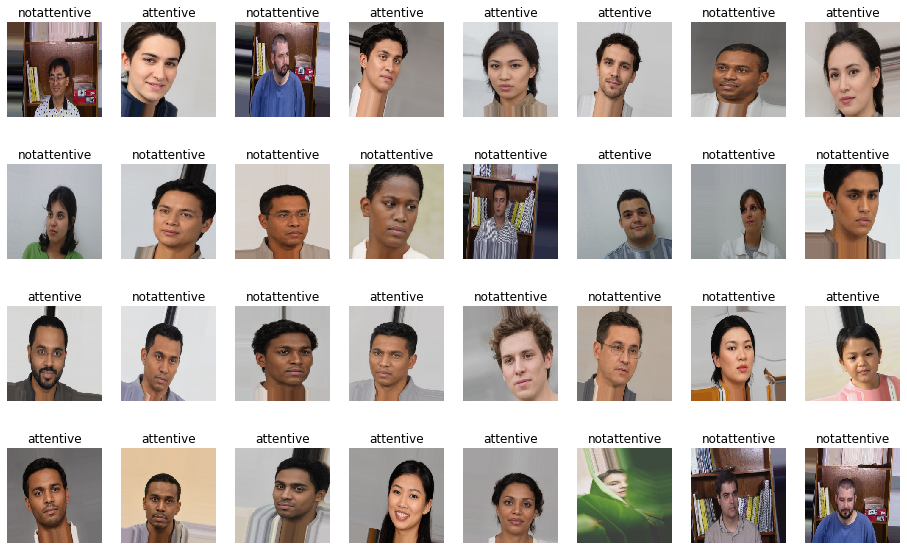

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=15,
      width_shift_range=0.15,
      height_shift_range=0.15,
      zoom_range=[1,1.5],
      fill_mode='nearest')
data_generator = datagen.flow_from_directory(
        TRAIN_PATH,  
        target_size=image_size,  
        batch_size=batch_size,
        class_mode='binary')

x, y = data_generator.next()

plt.figure(figsize=(16, 10))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(4, 8, i+1)
    if label == 1:
        plt.title('notattentive')
    else:
        plt.title('attentive') # automatically labeled zero (subdirectories are labeled in alphabetical order)
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

<p><a name="Transfer Learning"></a></p>

## Transfer Learning: Fine-Tuning

<p><a name="Load and Modify"></a></p>

### Load and Modify
Using a CNN pre-trained on a very large dataset, such as ImageNet, would yield much better results than training the CNN myself on a much more limited dataset. 
ResNet-152 was chosen due to better performance compared to other architectures. Its deepness is a big contributor to its effectiveness. ResNet-152 is trained on a subset of the ImageNet dataset consisting of 1.2 million images with 1000 categories.

Paper: https://arxiv.org/abs/1512.03385

In [3]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

# Load the ResNet152 model without the top fully-connected layers 
# since I will construct my own.
conv_base = ResNet152V2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [4]:
# The new head of the ResNet network
res_model = conv_base.output
res_model = MaxPooling2D((3, 3))(res_model)
res_model = Flatten()(res_model)
res_model = Dense(512, activation="relu")(res_model)
res_model = Dropout(0.5)(res_model)
res_model = Dense(1, activation='sigmoid')(res_model)

# Combine the ResNet model with its new head
model = Model(inputs=conv_base.input, outputs=res_model)


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 62,526,977
Trainable params: 62,383,233
Non-trainable params: 143,744
__________________________________________________________________________________________________


- In order to benefit from the pre-training the convolutional base must be kept as-is. The base layers are frozen, preventing their weights from getting updated duing training. Only the new head is trained.

In [6]:
# Shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
True

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
True

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
True

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
True

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
True

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
True

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
True

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
True

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
True

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
True

11: <tensorflow.python.

In [ ]:
# Freezes the layers in the base model
for layer in conv_base.layers:
    layer.trainable = False

In [7]:
# Again shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

<p><a name="Training"></a></p>

### Training
**Callbacks** are defined in order to mitigate overfitting by training for the optimal number of epochs and ensuring that the best model that results in the highest accuracy is saved. 

I run TensorBoard, TensorFlow's visualization toolkit in order to view live visual metrics.

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
%load_ext tensorboard
%tensorboard --logdir './resnet152v2/logs'
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(
            train_generator,
            steps_per_epoch=None, #366, #7302/20, 20 is the batch size
            validation_steps=None, #79, #1561/20
            epochs=200, # Change this to a bigger number if you want to train for more epochs
            validation_data=validation_generator,
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs')])

Reusing TensorBoard on port 6006 (pid 29404), started 1 day, 0:28:00 ago. (Use '!kill 29404' to kill it.)

C:\Users\Tyrone\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
229/229 [==============================] - 1546s 7s/step - loss: 1.0019 - accuracy: 0.6845 - val_loss: 0.5148 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71365, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 2/200
229/229 [==============================] - 1492s 7s/step - loss: 0.5112 - accuracy: 0.7399 - val_loss: 0.5157 - val_accuracy: 0.7034

Epoch 00002: val_accuracy did not improve from 0.71365
Epoch 3/200
229/229 [==============================] - 1492s 7s/step - loss: 0.4907 - accuracy: 0.7462 - val_loss: 0.4750 - val_accuracy: 0.7406

Epoch 00003: val_accuracy improved from 0.71365 to 0.74055, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 4/200
229/229 [==============================] - 1486s 6s/step - loss: 0.4891 - accuracy: 0.7495 - val_loss: 0.5154 - val_accuracy: 0.7021

Epoch 00004: val_accuracy did not improve from 0.74055
Epoch 5/200
229/229 [==============================] - 1489s 7s/step - loss: 

229/229 [==============================] - 1786s 8s/step - loss: 0.4272 - accuracy: 0.7825 - val_loss: 0.4343 - val_accuracy: 0.7521

Epoch 00040: val_accuracy did not improve from 0.76233
Epoch 41/200
229/229 [==============================] - 1702s 7s/step - loss: 0.4218 - accuracy: 0.7917 - val_loss: 0.4335 - val_accuracy: 0.7489

Epoch 00041: val_accuracy did not improve from 0.76233
Epoch 42/200
229/229 [==============================] - 1670s 7s/step - loss: 0.4080 - accuracy: 0.7990 - val_loss: 0.4400 - val_accuracy: 0.7521

Epoch 00042: val_accuracy did not improve from 0.76233
Epoch 43/200
229/229 [==============================] - 1537s 7s/step - loss: 0.4164 - accuracy: 0.7928 - val_loss: 0.4449 - val_accuracy: 0.7636

Epoch 00043: val_accuracy improved from 0.76233 to 0.76361, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 44/200
229/229 [==============================] - 2918s 13s/step - loss: 0.4134 - accuracy: 0.7866 - val_loss: 0.4580 - val_accuracy: 0.75


Epoch 00079: val_accuracy did not improve from 0.77194
Epoch 80/200
229/229 [==============================] - 1481s 6s/step - loss: 0.3972 - accuracy: 0.7973 - val_loss: 0.4268 - val_accuracy: 0.7585

Epoch 00080: val_accuracy did not improve from 0.77194
Epoch 81/200
229/229 [==============================] - 1482s 6s/step - loss: 0.4031 - accuracy: 0.7929 - val_loss: 0.4227 - val_accuracy: 0.7630

Epoch 00081: val_accuracy did not improve from 0.77194
Epoch 82/200
229/229 [==============================] - 1483s 6s/step - loss: 0.4074 - accuracy: 0.7954 - val_loss: 0.4231 - val_accuracy: 0.7751

Epoch 00082: val_accuracy improved from 0.77194 to 0.77514, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 83/200
229/229 [==============================] - 1487s 6s/step - loss: 0.4007 - accuracy: 0.7966 - val_loss: 0.4168 - val_accuracy: 0.7546

Epoch 00083: val_accuracy did not improve from 0.77514
Epoch 84/200
229/229 [==============================] - 1514s 7s/step - los


Epoch 00119: val_accuracy did not improve from 0.77707
Epoch 120/200
229/229 [==============================] - 1289s 6s/step - loss: 0.3902 - accuracy: 0.8084 - val_loss: 0.4312 - val_accuracy: 0.7681

Epoch 00120: val_accuracy did not improve from 0.77707
Epoch 121/200
229/229 [==============================] - 1290s 6s/step - loss: 0.3902 - accuracy: 0.8017 - val_loss: 0.4193 - val_accuracy: 0.7675

Epoch 00121: val_accuracy did not improve from 0.77707
Epoch 122/200
229/229 [==============================] - 1297s 6s/step - loss: 0.3971 - accuracy: 0.7977 - val_loss: 0.4170 - val_accuracy: 0.7668

Epoch 00122: val_accuracy did not improve from 0.77707
Epoch 123/200
229/229 [==============================] - 1302s 6s/step - loss: 0.3931 - accuracy: 0.8047 - val_loss: 0.4419 - val_accuracy: 0.7700

Epoch 00123: val_accuracy did not improve from 0.77707
Epoch 124/200
229/229 [==============================] - 1287s 6s/step - loss: 0.3957 - accuracy: 0.7969 - val_loss: 0.4268 - val_ac

229/229 [==============================] - 1247s 5s/step - loss: 0.3830 - accuracy: 0.8042 - val_loss: 0.4382 - val_accuracy: 0.7662

Epoch 00160: val_accuracy did not improve from 0.77707
Epoch 161/200
229/229 [==============================] - 1320s 6s/step - loss: 0.3874 - accuracy: 0.8028 - val_loss: 0.4429 - val_accuracy: 0.7591

Epoch 00161: val_accuracy did not improve from 0.77707
Epoch 162/200
229/229 [==============================] - 1330s 6s/step - loss: 0.3935 - accuracy: 0.7994 - val_loss: 0.4100 - val_accuracy: 0.7668

Epoch 00162: val_accuracy did not improve from 0.77707
Epoch 163/200
229/229 [==============================] - 1412s 6s/step - loss: 0.3861 - accuracy: 0.8055 - val_loss: 0.4165 - val_accuracy: 0.7649

Epoch 00163: val_accuracy did not improve from 0.77707
Epoch 164/200
229/229 [==============================] - 1458s 6s/step - loss: 0.3865 - accuracy: 0.8021 - val_loss: 0.4234 - val_accuracy: 0.7566

Epoch 00164: val_accuracy did not improve from 0.77707

229/229 [==============================] - 1300s 6s/step - loss: 0.3681 - accuracy: 0.8135 - val_loss: 0.4349 - val_accuracy: 0.7694

Epoch 00200: val_accuracy did not improve from 0.77707


Doesn't seem like the model restored the best weights...

In [10]:
# I save the final model to disk
model.save("./resnet152v2/model", save_format="h5")

- The loss and accuracy of the model over the training and validation data during training are plotted, and the plots are saved:

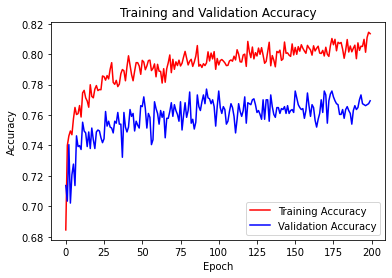

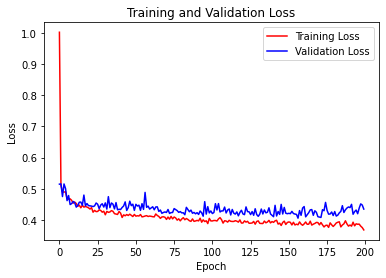

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy1.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss1.jpg')

plt.show()

- The model is evaluated against the test data.

In [12]:
test_loss, test_acc = model.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 250s 5s/step - loss: 0.4207 - accuracy: 0.7545


- Load best model and verify results.

In [13]:
from tensorflow.keras.models import load_model
model2 = load_model('./resnet152v2/attentions_resnet152v2.h5')

In [14]:
test_generator.reset()
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 247s 5s/step - loss: 0.4209 - accuracy: 0.7615


<p><a name="Re-training"></a></p>

### Re-training
I'll unfreeze a portion of the final convolutional layers in the ResNet-152 model then fine-tune those layers alongside the fully-connected layers I constructed previously.

In [15]:
# Shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
False

11: <tensorfl

In [16]:
# Unfreeze the last convulutional block in ResNet152
for layer in conv_base.layers[528:]:
    layer.trainable = True

In [17]:
# Again, shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
False

11: <tensorfl

In [23]:
# Reset the data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [24]:
# I use the same optimizer with a smaller learning reate
from tensorflow.keras.optimizers import Adam
opt=Adam(learning_rate=1e-4)

In [22]:
# Retrain the top layers of the model
# %reload_ext tensorboard
# %tensorboard --logdir './resnet152v2/logs_2'
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, mode='min', restore_best_weights=True)

history_2 = model.fit(
            train_generator,
            steps_per_epoch=None, 
            validation_steps=None, 
            epochs=200, 
            validation_data=validation_generator,
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs_2')])

C:\Users\Tyrone\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
229/229 [==============================] - 1274s 6s/step - loss: 0.3980 - accuracy: 0.8010
Epoch 2/200
229/229 [==============================] - 1149s 5s/step - loss: 0.3907 - accuracy: 0.7976
Epoch 3/200
229/229 [==============================] - 1205s 5s/step - loss: 0.3818 - accuracy: 0.8061
Epoch 4/200
229/229 [==============================] - 1146s 5s/step - loss: 0.3838 - accuracy: 0.8038
Epoch 5/200
229/229 [==============================] - 1160s 5s/step - loss: 0.3829 - accuracy: 0.8080
Epoch 6/200
229/229 [==============================] - 1160s 5s/step - loss: 0.3773 - accuracy: 0.8062
Epoch 7/200
229/229 [==============================] - 1159s 5s/step - loss: 0.3787 - accuracy: 0.8048
Epoch 8/200
229/229 [==============================] - 1151s 5s/step - loss: 0.3751 - accuracy: 0.8137
Epoch 9/200
229/229 [==============================] - 1157s 5s/step - loss: 0.3789 - accuracy: 0.8085
Epoch 10/200
229/229 [==============================] - 1137s 5s/step - l

229/229 [==============================] - 1122s 5s/step - loss: 0.3763 - accuracy: 0.8127
Epoch 28/200
229/229 [==============================] - 1122s 5s/step - loss: 0.3796 - accuracy: 0.8084
Epoch 29/200
229/229 [==============================] - 1119s 5s/step - loss: 0.3784 - accuracy: 0.8081
Epoch 30/200
229/229 [==============================] - 1124s 5s/step - loss: 0.3767 - accuracy: 0.8065
Epoch 31/200
229/229 [==============================] - 1107s 5s/step - loss: 0.3748 - accuracy: 0.8096
Epoch 32/200
229/229 [==============================] - 1111s 5s/step - loss: 0.3739 - accuracy: 0.8109
Epoch 33/200
229/229 [==============================] - 1121s 5s/step - loss: 0.3809 - accuracy: 0.8133
Epoch 34/200
229/229 [==============================] - 1123s 5s/step - loss: 0.3817 - accuracy: 0.8096
Epoch 35/200
229/229 [==============================] - 1102s 5s/step - loss: 0.3797 - accuracy: 0.8099
Epoch 36/200
229/229 [==============================] - 1109s 5s/step - loss:

229/229 [==============================] - 1098s 5s/step - loss: 0.3813 - accuracy: 0.8094
Epoch 54/200
229/229 [==============================] - 1090s 5s/step - loss: 0.3764 - accuracy: 0.8070
Epoch 55/200
229/229 [==============================] - 1097s 5s/step - loss: 0.3698 - accuracy: 0.8129
Epoch 56/200
229/229 [==============================] - 1101s 5s/step - loss: 0.3753 - accuracy: 0.8094
Epoch 57/200
229/229 [==============================] - 1083s 5s/step - loss: 0.3834 - accuracy: 0.8079
Epoch 58/200
229/229 [==============================] - 1101s 5s/step - loss: 0.3680 - accuracy: 0.8139
Epoch 59/200
229/229 [==============================] - 1089s 5s/step - loss: 0.3731 - accuracy: 0.8110
Epoch 60/200
229/229 [==============================] - 1086s 5s/step - loss: 0.3733 - accuracy: 0.8110
Epoch 61/200
229/229 [==============================] - 1099s 5s/step - loss: 0.3749 - accuracy: 0.8131
Epoch 62/200
229/229 [==============================] - 1082s 5s/step - loss:

KeyboardInterrupt: 

In [ ]:
# Plot the loss and accuracy of the model over the training and validation data 
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy_2.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss_2.jpg')

plt.show()

- Evaluate and compare:

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

In [ ]:
model3 = load_model('./resnet152v2/attentions_resnet152v2_2.h5')

test_generator.reset()
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

<p><a name="Video Classification"></a></p>

## Video Classification

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('./resnet152v2/attentions_resnet152v2.h5')

In [ ]:
import cv2 as cv
import numpy as np

VIDEO_NAME = "Example1.mp4"
VIDEO_IN = "videos/in/"
VIDEO_OUT = "videos/out/"

frame_width, frame_height = None, None

classes = ['ATTENTIVE', 'NOT ATTENTIVE']

# Capturing videoclip or livestream
capturing = VIDEO_IN+VIDEO_NAME # videoclip
capturing = 0 # livestream; webcam

cap = cv.VideoCapture(capturing)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
    
writer = None

In [ ]:
# Loop over frames from the video stream
while True:
    # Capture frame-by-frame
    is_present, frame = cap.read()

    # If is_present is false, frame was read incorrectly or we have 
    # reached the end of the video
    if not is_present:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Get frame dimensions if empty
    if frame_width is None or frame_height is None:
        frame_width, frame_height = frame.shape[:2]
        
    # Operations on the frame: Convert, Resize, Rescale
    output = frame.copy()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame = cv.resize(frame, (224, 224)).astype("float32")
    frame /= 255
    
    # Label the current frame
    percent_pred = model2.predict(np.expand_dims(frame, axis=0))[0]
    percent_pred = float(*percent_pred)*100
    preds = 0 if percent_pred < 99 else 1

    label = classes[preds]    

    # Write the label on the output frame
    text = f"{label}: {percent_pred}%"
    org = (35, 50)
    font = cv.FONT_HERSHEY_DUPLEX
    fontScale = 1.25
    color = (0, 255, 0)
    thickness = 3
    cv.putText(output, text, org, font, fontScale, color, thickness)
    
    # Check if videowriter is None
    if writer is None:
        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*"DIVX")
        writer = cv.VideoWriter(VIDEO_OUT+VIDEO_NAME, fourcc, 30,
            (frame_width, frame_height), True)
        
    # Write output frame to disk
    writer.write(output)
    
    # Show output images
    cv.imshow("Output", output)
    
    # Break loop when 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord("q"):
        break
        
# Rrelease the file pointers
cap.release()
writer.release()

# Close all windows
cv.destroyAllWindows()